In [ ]:
# Copyright 2023 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [1]:
# Skip this cell if running from local environment
!pip install -q --no-warn-conflicts git+https://github.com/google-deepmind/nuclease_design.git
# After installing, restart the kernel
# Then run cells as normal

# Imports

In [3]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from nuclease_design import utils
from nuclease_design import plotting
from nuclease_design import constants

# Constants

In [4]:
RANDOM_SEED = 0
DEFAULT_NUM_BOOTSTRAPS = 1000
RANDOM_STATE = np.random.RandomState(RANDOM_SEED)

In [5]:
DATA_DIR = constants.DATA_DIR

# Helper fns

In [6]:
def parse_activity_df_from_xml(activity_path):
  with utils.open_file(activity_path, 'rb', DATA_DIR) as f:
    tree = ET.parse(f)
    root = tree.getroot()

  well_dfs = []
  for sections in root.iter('PlateSection'):
      if (sections.attrib['Name'] != 'Plate1'):
        raise ValueError(f'Unexpected Plate {sections.attrib["Name"]}')
      for well in sections.iter('Well'):
          fluorescence = pd.Series(well.find('RawData').text.split(), dtype=float)
          time = pd.Series(well.find('TimeData').text.split(), dtype=float) / 60  # seconds to minutes
          well = well.get('Name')
          well_dfs.append(pd.DataFrame({'well': well, 'fluorescence': fluorescence, 'time': time}))
  return pd.concat(well_dfs, ignore_index=True)


In [7]:
# The number of points used here is to guarantee that we are measuring
# initial velocity in the linear regime of the reaction
# See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4692135/ "Properties and mechanisms of enzyme action"
# for details
def add_initial_velocity(df, num_points=10):
  df = df.sort_values(by=['time'], ascending=True)
  x = df['time'][:num_points]
  y = df['fluorescence'][:num_points]

  result = stats.linregress(x, y, alternative='two-sided')

  slope_stderr = result.stderr
  slope = result.slope
  return pd.Series({'initial_velocity': slope, 'initial_velocity_stderr': slope_stderr, 'intercept': result.intercept})

# The wildtype is a particularly slow reaction, so we have many more points in
# the linear regime.
def add_initial_velocity_wrapper(df):
  if df.genotype.unique().item() == 'wild type':
    return add_initial_velocity(df, num_points=100)
  else:
    return add_initial_velocity(df)

def parametric_resample_row(row, random_state, n_bootstraps):
  mean = row['initial_velocity']
  stdev = row['initial_velocity_stderr']
  return random_state.normal(loc=mean, scale=stdev, size=n_bootstraps)

def get_bootstrapped_initial_velocity_df(df, random_state, n_bootstraps=DEFAULT_NUM_BOOTSTRAPS):
  return df.apply(parametric_resample_row, axis=1, random_state=random_state, n_bootstraps=n_bootstraps)


# Read in plate data

In [8]:
with utils.open_file(constants.PLATE_GENOTYPES_PATH, 'r', DATA_DIR) as f:
  genotypes_df = pd.read_csv(f)

In [9]:
platemap = {
    'O403':  ['A1', 'A2', 'A3', 'A4'],
    'O1757': ['C1', 'C2', 'C3', 'C4'],
    'O2360': ['E1', 'E2', 'E3', 'E4'],
    'O3188': ['G1', 'G2', 'G3', 'G4'],
    'O3459': ['I1', 'I2', 'I3', 'I4'],
    'O3512': ['K1', 'K2', 'K3', 'K4'],
    'O3513': ['M1', 'M2', 'M3', 'M4'],
    'O4060': ['O1', 'O2', 'O3', 'O4'],
}

well_to_strain = {}
for strain, wells in platemap.items():
  for well in wells:
    well_to_strain[well] = strain

well_to_concentration = {}
for row in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'O']:
  for concentration, column in zip([100, 50, 25, 12.5], ['1', '2', '3', '4']):
    well_to_concentration[''.join([row, column])] = concentration

In [10]:
df = parse_activity_df_from_xml(constants.TIME_SERIES_ACTIVITY_XML_PATH)
df['strain'] = df['well'].apply(well_to_strain.get)
df.dropna(subset=['strain'], inplace=True)
df = df[df['strain'] != 'O403']  # Removing WT assessed in a different background strain
df = df.merge(genotypes_df, how='left', on='strain')
df['concentration'] = df['well'].apply(well_to_concentration.get)

# Compute enzyme reaction rate

## Example of fitting reaction trajectory in linear regime

In [11]:
slope = add_initial_velocity(df[df.well == 'K1'])['initial_velocity']
stderr = add_initial_velocity(df[df.well == 'K1'])['initial_velocity_stderr']
intercept = add_initial_velocity(df[df.well == 'K1'])['intercept']

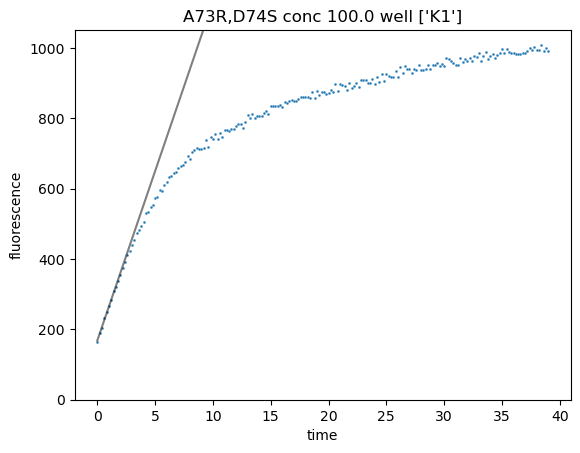

In [12]:
plotdf = df[(df['well'] == 'K1')]
sns.scatterplot(data=plotdf, x='time', y='fluorescence', s=4)
plt.ylim(bottom=0)
plt.plot(plotdf.time, intercept + slope * plotdf.time, 'black', alpha=0.5, label='initial velocity fit')
plt.title(f'{plotdf.genotype.iloc[0]} conc {plotdf.concentration.iloc[0]} well {plotdf["well"].unique()}')
plt.show()

## Add bootstrapped estimates of the rate

In [13]:
initial_velocity_df = df.groupby(['strain', 'genotype', 'concentration'], group_keys=True).apply(add_initial_velocity_wrapper).reset_index()
initial_velocity_df['initial_velocity_resampled'] = get_bootstrapped_initial_velocity_df(initial_velocity_df, RANDOM_STATE)
bootstrapped_initial_velocity_df = initial_velocity_df.explode('initial_velocity_resampled')

/var/folders/x_/g9qv4tyj4kd1m4zrz61_t4700000gn/T/ipykernel_58463/3321433837.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  initial_velocity_df = df.groupby(['strain', 'genotype', 'concentration'], group_keys=True).apply(add_initial_velocity_wrapper).reset_index()


In [14]:
bootstrapped_initial_velocity_df.head()

,strain,genotype,concentration,initial_velocity,initial_velocity_stderr,intercept,initial_velocity_resampled
0,O1757,wild type,12.5,1.003808,0.025534,127.776027,1.048852
0,O1757,wild type,12.5,1.003808,0.025534,127.776027,1.014026
0,O1757,wild type,12.5,1.003808,0.025534,127.776027,1.028799
0,O1757,wild type,12.5,1.003808,0.025534,127.776027,1.061027
0,O1757,wild type,12.5,1.003808,0.025534,127.776027,1.051494


# Purified Protein Plot

In [15]:
genotype_to_library = {
    'wild type': 'WT',
    'A73R': 'epPCR',
    'A73R,D74S': 'ML2',
    'A63P,A73R,D74H,I84Y': 'ML3',
    'A63S,D64S,A73R': 'DE3',
    'D64A,A73R': 'ML2B',  # Also ML2
    'A63S,A132P': 'DE3B', # Internal DE. (sorted from OB174)
}
genotype_order = ('wild type', 'A73R', 'A73R,D74S', 'A63S,D64S,A73R', 'A63P,A73R,D74H,I84Y')
library_order = tuple(genotype_to_library[genotype] for genotype in genotype_order)

EPPCR_COLOR = sns.color_palette("muted")[0]
ML2_COLOR = ML3_COLOR = sns.color_palette("muted")[1]
DE3_COLOR = sns.color_palette("muted")[2]

custom_palette = (plotting.WT_COLOR, EPPCR_COLOR, ML2_COLOR, DE3_COLOR, ML3_COLOR)

In [16]:
# add fields
bootstrapped_initial_velocity_df['activity'] = bootstrapped_initial_velocity_df['initial_velocity_resampled']
bootstrapped_initial_velocity_df['library'] = bootstrapped_initial_velocity_df.genotype.apply(genotype_to_library.get)

# remove other genotypes
bootstrapped_initial_velocity_df = bootstrapped_initial_velocity_df[bootstrapped_initial_velocity_df.genotype.isin(genotype_order)]

In [17]:
bootstrapped_initial_velocity_df.genotype.unique()

array(['wild type', 'A73R', 'A73R,D74S', 'A63P,A73R,D74H,I84Y',
       'A63S,D64S,A73R'], dtype=object)

In [18]:
def get_activity_relative_to_wt(df):
  wt_activities = df[df.genotype == 'wild type']['activity'].sample(n=len(df.activity), replace=True)
  df['fold_change_activity'] = df['activity'] / wt_activities.values
  return df

In [19]:
normalized_df = bootstrapped_initial_velocity_df.groupby(by='concentration', group_keys=False).apply(get_activity_relative_to_wt)

/var/folders/x_/g9qv4tyj4kd1m4zrz61_t4700000gn/T/ipykernel_58463/3233985347.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = bootstrapped_initial_velocity_df.groupby(by='concentration', group_keys=False).apply(get_activity_relative_to_wt)


In [20]:
FRACTION_OF_WILDTYPE_ACTIVITY = 0.178  # in Tris buffer at pH 7
WILDTYPE_PH_9_ACTIVITY = 1 / FRACTION_OF_WILDTYPE_ACTIVITY

/Users/nthomas/git/nuclease_design/nuclease_design/plotting.py:328: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Text(0.5, 0, '')

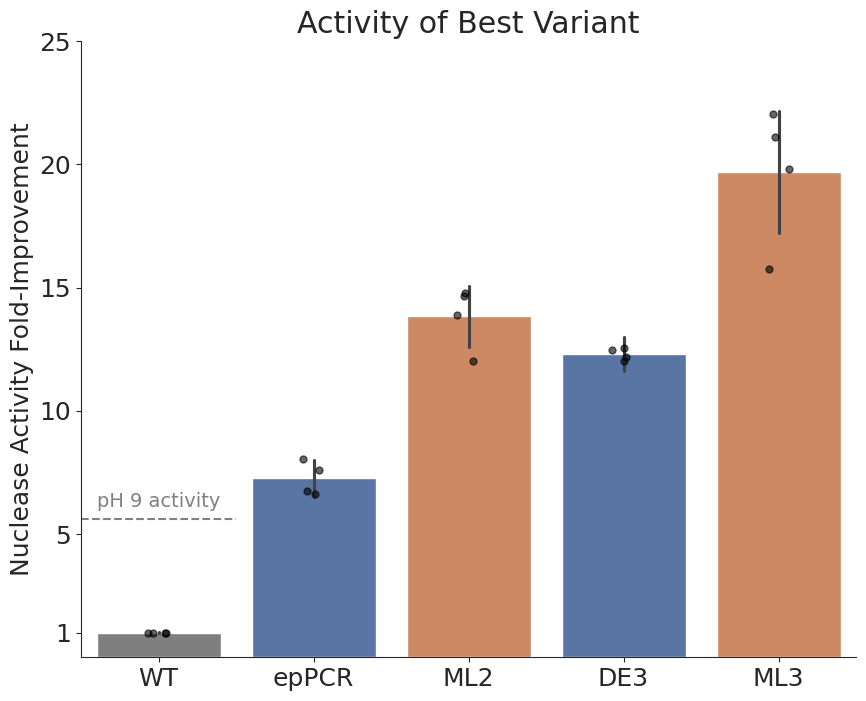

In [29]:
EPPCR_COLOR = DE3_COLOR = sns.color_palette("deep")[0]
ML2_COLOR = ML3_COLOR = sns.color_palette("deep")[1]

# ML2_COLOR = ML3_COLOR = "#cb845c"
# EPPCR_COLOR = DE3_COLOR = "#5c7cab"
custom_palette = (plotting.WT_COLOR, EPPCR_COLOR, ML2_COLOR, DE3_COLOR, ML3_COLOR)


# increase fontsize
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10, 8))
ax = plotting.plot_purified_protein_activity(
    normalized_df,
    library_order=library_order,
    custom_palette=custom_palette,
)

points_df = (
    normalized_df.groupby(by=['genotype', 'concentration'])
    .agg({'fold_change_activity': 'mean'})
    .reset_index()
)
points_df['library'] = points_df.genotype.apply(genotype_to_library.get)
sns.stripplot(
    data=points_df,
    x='library',
    y='fold_change_activity',
    order=library_order,
    marker='o',
    facecolors='black',
    edgecolor='black',
    linewidth=1,
    alpha=0.6,
    ax=ax,
)
# horizontal line
plt.axhline(y=WILDTYPE_PH_9_ACTIVITY, color='0.5', linestyle='--', xmin=0, xmax=.2)
# add text annotation above line
plt.text(-0.4, WILDTYPE_PH_9_ACTIVITY + 0.5, 'pH 9 activity', color='0.5', fontsize=14)
plt.xlabel('')